In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

# Импорт библиотек

In [7]:
!pip install keras_preprocessing

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model

from pathlib import Path
import os.path
import random

import matplotlib.cm as cm
import cv2
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
import itertools

import warnings
warnings.filterwarnings("ignore")

# Импорт датасета

In [31]:
dataset_dir = '/kaggle/input/100-bird-species/'
train_dir = '/kaggle/input/100-bird-species/test'
val_dir = '/kaggle/input/100-bird-species/valid'
test_dir = '/kaggle/input/100-bird-species/test'

In [10]:
train_imgs = [os.path.join(train_dir, filename) for filename in os.listdir(train_dir)]
val_imgs = [os.path.join(val_dir, filename) for filename in os.listdir(val_dir)]
test_imgs = [os.path.join(test_dir, filename) for filename in os.listdir(test_dir)]

In [11]:
df_all = pd.read_csv('/kaggle/input/100-bird-species/birds.csv')
df_train = df_all.loc[df_all['data set'] == 'train']
df_val = df_all.loc[df_all['data set'] == 'valid']
df_test = df_all.loc[df_all['data set'] == 'test']
print('Размер train: ', df_train.shape)
print('Размер val: ', df_val.shape)
print('Размер test: ', df_test.shape)

Размер train:  (84635, 5)
Размер val:  (2625, 5)
Размер test:  (2625, 5)


In [12]:
df_train.head()

,class id,filepaths,labels,data set,scientific name
0,0.0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0.0,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0.0,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0.0,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0.0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI


In [13]:
df_train.isnull().sum()

class id           0
filepaths          0
labels             0
data set           0
scientific name    0
dtype: int64

Приведем метки классов к целочисленному типу

In [14]:
df_train['class id'] = df_train['class id'].apply(int)
df_val['class id'] = df_val['class id'].apply(int)
df_test['class id'] = df_test['class id'].apply(int)
df_train.head()

,class id,filepaths,labels,data set,scientific name
0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI


In [15]:
for col in df_train.columns.tolist():
    print(f'Уникальных значений в столбце {col}: {len(df_train[col].unique())}')

Уникальных значений в столбце class id: 525
Уникальных значений в столбце filepaths: 84635
Уникальных значений в столбце labels: 525
Уникальных значений в столбце data set: 1
Уникальных значений в столбце scientific name: 522


Заметим, что уникальных научных названий меньше, чем неофициальных. Так как пропусков нет, на некоторые научные названия приходится несколько неофициальных. 

Составим словарь, где ключами будут метки класса, а значениями -- названия видов птиц, а также словарь, где ключами будут названия видов птиц, а значениями -- научные названия видов птиц

In [16]:
class_name = {}
def name_matching(row):
    class_name[row['class id']] = row['labels']
df_val.apply(name_matching, axis=1)
len(class_name)

525

In [17]:
sci_name = {}
def sci_name_matching(row):
    sci_name[row['labels']] = row['scientific name']
df_val.apply(sci_name_matching, axis=1)
len(sci_name)

525

# Просмотр изображений

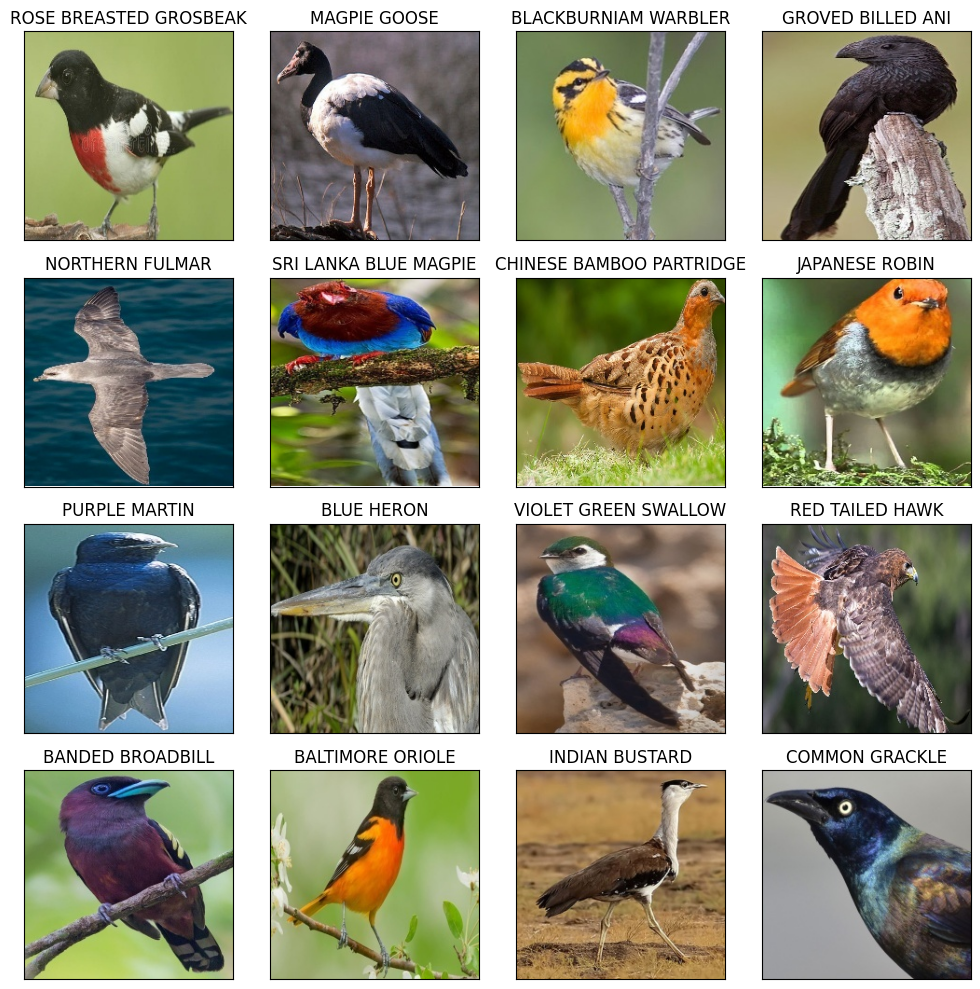

In [33]:
random_index = np.random.randint(0, len(df_train), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(dataset_dir + df_train['filepaths'][random_index[i]]))
    ax.set_title(df_train['labels'][random_index[i]])
plt.tight_layout()
plt.show()

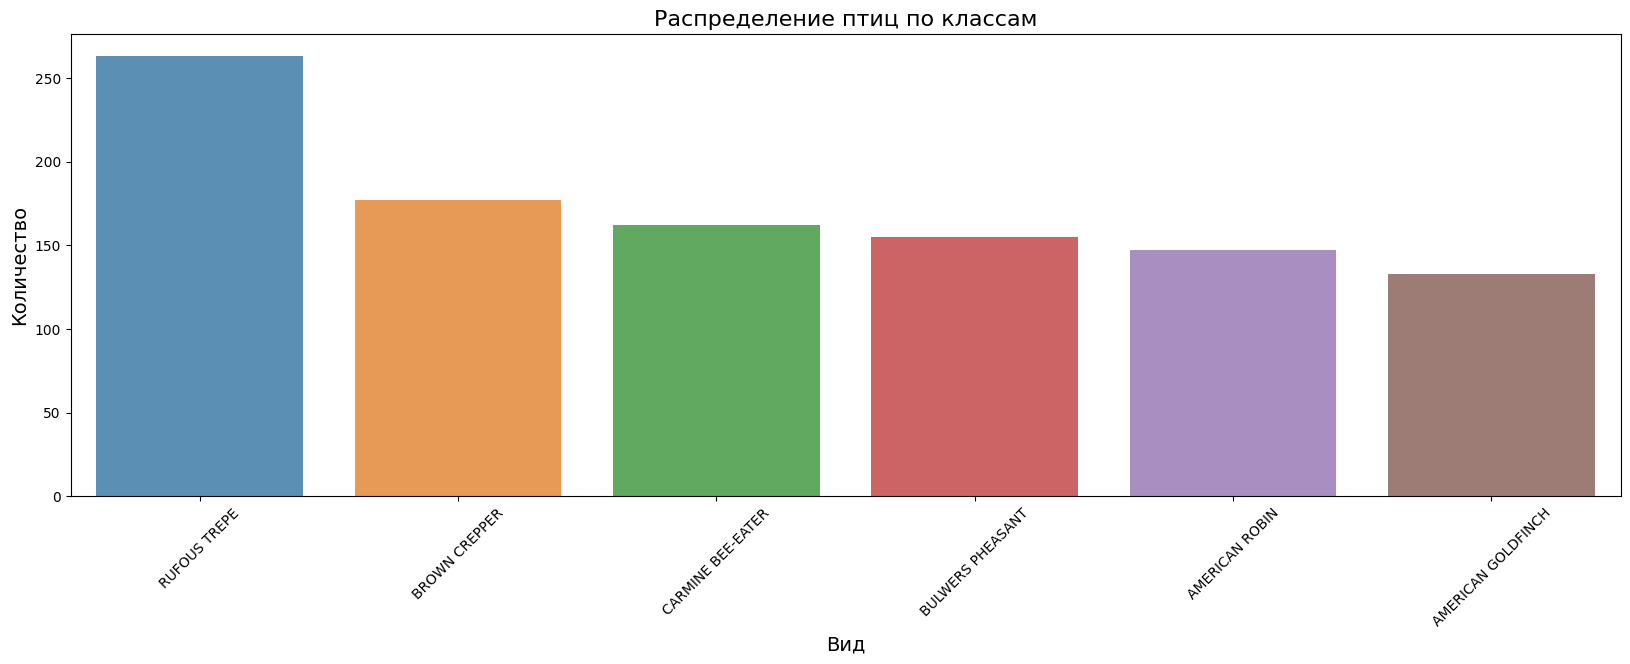

In [23]:
# Проредим список для наглядности
all_label_counts = df_train['labels'].value_counts()
bar_labels = all_label_counts[::100]

plt.figure(figsize=(20, 6))
sns.barplot(x=bar_labels.index, y=bar_labels.values, alpha=0.8)
plt.title('Распределение птиц по классам', fontsize=16)
plt.xlabel('Вид', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [30]:
print(f'Самый многочисленный класс представлен в выборке в {round(all_label_counts.max() / all_label_counts.min(), 2)} раза больше, чем самый малочисленный')

Самый многочисленный класс представлен в выборке в 2.02 раза больше, чем самый малочисленный


Заметим, что в датасете наблюдается серьезная диспропорция классов. На это необходимо будет обратить внимание при выборе модели.

Оставим от датасета только метки класса и путь к изображению птицы

In [ ]:
'''
df_train = df_train[['filepaths', 'class id']]
df_val = df_val[['filepaths', 'class id']]
df_test = df_test[['filepaths', 'class id']]
df_train.head()
'''